In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import scipy

In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from UKMovementSensing import hsmm
from milleniumcohort import create_config

In [4]:
config = create_config('../config.yml')
config.create_data_paths()

In [5]:
import sqlite3
conn = sqlite3.connect(os.path.join(config.model_path, 'milleniumcohort.db'))

## Load data in database

In [6]:
config.model_path

'/media/sf_VBox_Shared/London/CLSdata500/results/mod_10st_0b_15r_720t_acceleration_anglex_angley_anglez'

In [7]:
# Import data with states
filenames = os.listdir(config.states_path)
filenames = [fn for fn in filenames if os.path.isfile(os.path.join(config.states_path,fn))]

In [62]:
# Only do this if database is not filled yet!
fill_again = False
if(fill_again):
    c = conn.cursor()
    c.execute('drop table if exists data_with_states')
    for fn in filenames:
        dataset = pd.read_csv(os.path.join(config.states_path,fn), encoding='utf-8', index_col='timestamp', parse_dates=True)
        if len(dataset[dataset["state"].isnull()])>0 :
            print(fn)
        dataset.to_sql('data_with_states', conn, if_exists='append')


In [63]:
pd.read_sql('Select count(distinct filename), count(*) from data_with_states', conn)

,count(distinct filename),count(*)
0,912,14328000


In [64]:
pd.read_sql('pragma table_info(data_with_states)', conn)

,cid,name,type,notnull,dflt_value,pk
0,0,timestamp,TIMESTAMP,0,None,0
1,1,acceleration,REAL,0,None,0
2,2,EN,REAL,0,None,0
3,3,anglex,REAL,0,None,0
4,4,angley,REAL,0,None,0
5,5,anglez,REAL,0,None,0
6,6,roll_med_acc_x,REAL,0,None,0
7,7,roll_med_acc_y,REAL,0,None,0
8,8,roll_med_acc_z,REAL,0,None,0
9,9,dev_roll_med_acc_x,REAL,0,None,0


## Preperation

In [8]:
states = pd.read_sql('Select distinct state from data_with_states', conn)

In [9]:
len(states)

10

In [68]:
# Load simplified activities map
activities_simplified = pd.read_csv(config.activities_simplified_path, header=0, sep=',', dtype=str, encoding='utf-8')
levelmap = {'0': "low", '1': "high", '2':"mixed"}
def get_category_des(motion, arm_changes):
    return levelmap[motion]+" motion, " + levelmap[arm_changes] + " arm changes"
activities_simplified['simplified_category'] = [get_category_des(row[1], row[2]) for row in activities_simplified.get_values()]
#activities_simplified.to_sql('activities_simplified', conn)

In [73]:

heuristic_classes = [' 1 - sustained activity',  #1
                     ' 2 - non-bouted inactivity', #2
                     ' 3 - >=30min inactivity', #3 
                     ' 4 - 10-19min inactivity', #4
                     ' 5 - non-bouted LPA', #5
                     ' 6 - >=10min LPA', #6
                     ' 7 - 1-9min LPA', #7
                     ' 8 - non-bouted MVPA', #8
                     ' 9 - >=10min MVPA', #9
                    '10 - 1-9min MVPA' #10
                     ]
get_heuristic = lambda i: heuristic_classes[int(i)-1]

## Get subjects with >20 hour data

In [70]:
timecounts = pd.read_sql('Select filename, count(*) from data_with_states group by filename', conn)

In [71]:
timecounts = timecounts.set_index('filename')
timecounts.columns = ['cnt_5sec']
timecounts['cnt_hours'] = timecounts['cnt_5sec'] / (12.0 * 60)

In [72]:
if fill_again:
    timecounts.to_sql('timecounts', conn)

In [73]:
longdays = timecounts[timecounts['cnt_hours']>=24].index
longdays.shape

(541,)

## Calculate per-state statistics

In [15]:
numerical_columns = ['acceleration','EN',
        'anglex','angley',u'anglez',u'roll_med_acc_x',u'roll_med_acc_y',
        u'roll_med_acc_z',u'dev_roll_med_acc_x',
             u'dev_roll_med_acc_y',u'dev_roll_med_acc_z']
query = '''Select state, ''' +  ','.join(['avg({})'.format(co) for co in numerical_columns]) + '''
from data_with_states group by state'''

avg_bystate = pd.read_sql(query, conn)

In [16]:
avg_bystate = avg_bystate.set_index('state').transpose()
avg_bystate.index = numerical_columns

In [17]:
means = avg_bystate.loc[config.hsmmconfig.column_names]
means.style.background_gradient(cmap='coolwarm',axis=1)

state,0,1,2,3,4,5,6,7,8,9
acceleration,0.00646974,0.0558619,0.000596535,0.00735707,0.00777133,0.0425286,0.00958525,0.0581664,0.305186,4.21782e-05
anglex,-36.4826,-36.8815,30.2579,18.1635,-50.8805,21.4178,-50.7094,-39.6038,-27.299,4.16656
angley,44.5327,14.4891,-9.88565,16.0248,-2.27382,-1.73615,3.99627,-40.6321,-2.29156,6.92589
anglez,7.83418,-12.6328,38.4338,-36.589,35.7553,33.7239,-35.1441,-3.60862,2.95153,-48.469


In [18]:
# Get a practical ordering of the states: based on the mean acceleration values
state_order = means.loc['acceleration'].sort_values().index
state_order

Int64Index([9, 2, 0, 3, 4, 6, 5, 1, 7, 8], dtype='int64', name=u'state')

In [56]:
#Define consistent colormap
from matplotlib.colors import LinearSegmentedColormap
# One more than the number of states, so we have a color for 'All'
nr_states = 10 #len(states)
colormap, cmap = hsmm.get_color_map(nr_states+1)
cmap_states = LinearSegmentedColormap.from_list('name',
                                             [colormap[i] for i in range(nr_states)],
                                             nr_states)

In [28]:
avg_bystate.style.background_gradient(cmap='coolwarm',axis=1)

state,0,1,2,3,4,5,6,7,8,9
acceleration,0.00646974,0.0558619,0.000596535,0.00735707,0.00777133,0.0425286,0.00958525,0.0581664,0.305186,4.21782e-05
EN,1.00032,1.02203,1.0001,1.00095,1.00011,1.01741,1.0023,1.02631,1.23693,0.999745
anglex,-36.4826,-36.8815,30.2579,18.1635,-50.8805,21.4178,-50.7094,-39.6038,-27.299,4.16656
angley,44.5327,14.4891,-9.88565,16.0248,-2.27382,-1.73615,3.99627,-40.6321,-2.29156,6.92589
anglez,7.83418,-12.6328,38.4338,-36.589,35.7553,33.7239,-35.1441,-3.60862,2.95153,-48.469
roll_med_acc_x,-0.549974,-0.515041,0.442142,0.26944,-0.721177,0.307677,-0.72595,-0.569289,-0.373653,0.0530027
roll_med_acc_y,0.651715,0.207069,-0.135172,0.237441,-0.0383522,-0.0216416,0.0672668,-0.584106,-0.0369993,0.109171
roll_med_acc_z,0.125496,-0.178795,0.551189,-0.549837,0.538914,0.482733,-0.534467,-0.0586451,0.0505629,-0.705944
dev_roll_med_acc_x,0.00126651,0.00617619,-3.17011e-05,-0.00125535,0.00122177,-0.00478509,0.00242151,0.000979617,-0.0164387,1.50483e-05
dev_roll_med_acc_y,-0.000321613,-0.00439626,-5.53432e-05,-0.000126806,0.000374096,0.0002391,0.000580458,0.00436372,-0.0127647,-1.04088e-05


In [29]:
#Create random sample to do calculations on
sample = pd.read_sql(
    '''select state, heuristic, acceleration, anglex, angley, anglez
        from data_with_states
        where abs(random()%1) < 0.1 
    ''', conn)

In [30]:
sample.shape

(14328000, 6)

In [34]:
sample = sample.dropna()

In [100]:
sample['cut-off'] = [get_heuristic(i) for i in sample['heuristic']]

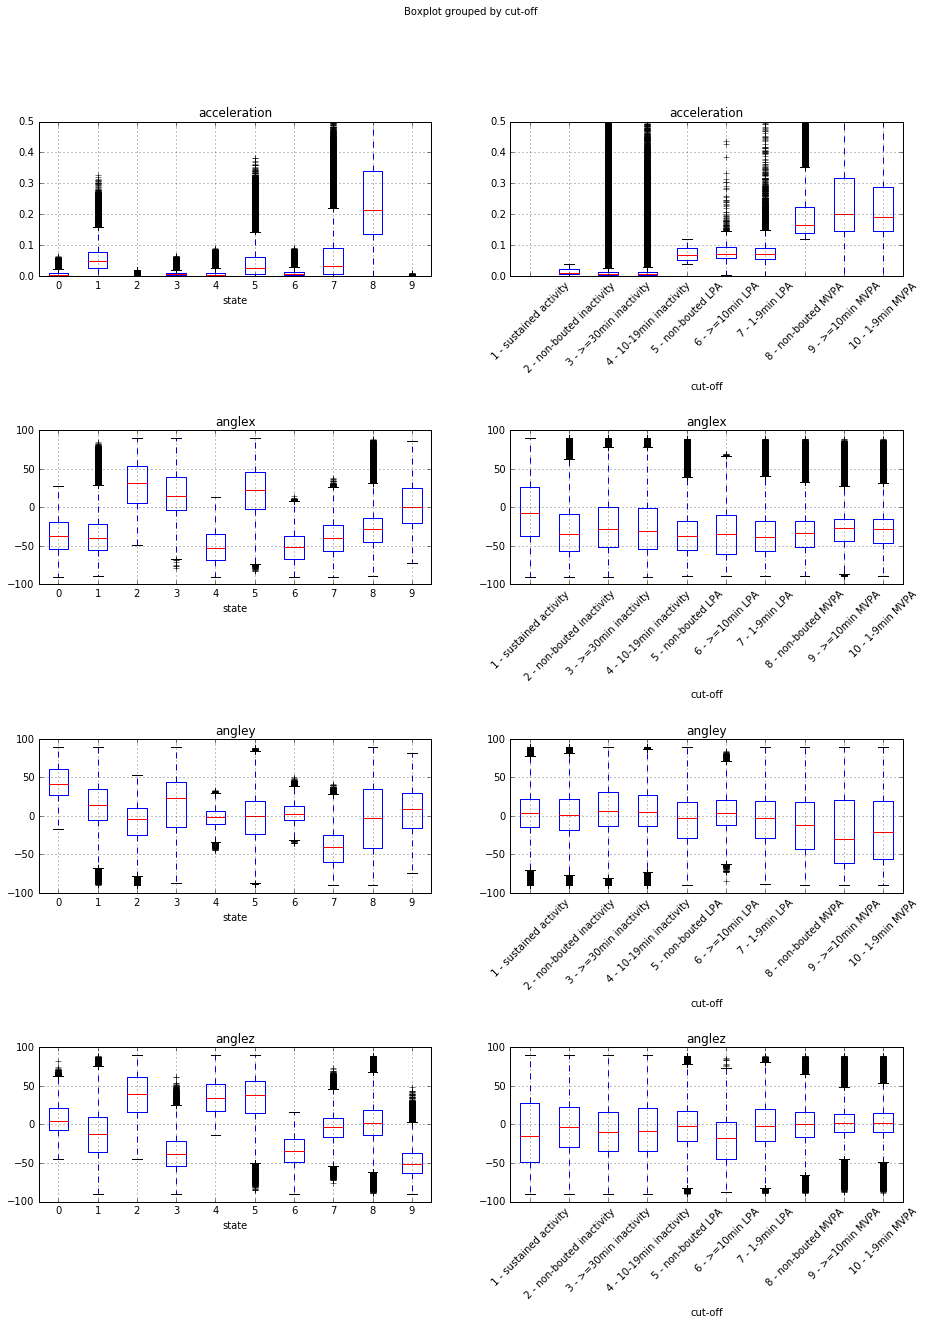

In [101]:
cols = ['acceleration', 'anglex', 'angley', 'anglez']
fig, axes = plt.subplots(len(cols), 2, figsize=(15, 20))
plt.subplots_adjust(hspace=1)
fig.set_label('')
sample.boxplot(by='state', column=cols, ax=axes[:,0])
sample.boxplot(by='cut-off', column=cols, ax=axes[:, 1], rot=45)
ymax_acc = 0.5
axes[0, 0].set_ylim(0, ymax_acc)
axes[0, 1].set_ylim(0, ymax_acc)
plt.savefig(os.path.join(config.image_path, 'boxplots.png'))

## Get sojourn times

In [20]:
data_sc = pd.read_sql('''select filename, subset, state, heuristic from data_with_states''', conn) 

In [21]:
data_sc['fn_s'] = data_sc['subset'].astype('str') + data_sc['filename']

In [22]:
def sojourn_times(df, colname):
    changepoints = (df[colname].shift(1) != df[colname]) | (df.fn_s.shift(1) != df.fn_s)
    df['block'] = changepoints.astype(int).cumsum()
    sojourn_times = df.groupby([colname, 'block'])['fn_s'].count()
    sojourn_times = sojourn_times.reset_index()[[colname, 'fn_s']]
    sojourn_times.columns = [colname, 'time']
    df.drop('block', 1)
    return sojourn_times

In [23]:
sojourn_times_state = sojourn_times(data_sc, 'state')

In [24]:
sojourn_times_cutoff = sojourn_times(data_sc, 'heuristic')

In [25]:
sojourn_times_state['time_sec'] = sojourn_times_state['time']*5
sojourn_times_cutoff['time_sec'] = sojourn_times_cutoff['time']*5
sojourn_times_state['time_min'] = sojourn_times_state['time']/12.0
sojourn_times_cutoff['time_min'] = sojourn_times_cutoff['time']/12.0

In [26]:
sojourn_times_cutoff['cut-off'] = [get_heuristic(i) for i in sojourn_times_cutoff['heuristic']]

In [27]:
sojourn_times_cutoff.head()

,heuristic,time,time_sec,time_min,cut-off
0,1,501,2505,41.750000,1 - sustained activity
1,1,609,3045,50.750000,1 - sustained activity
2,1,295,1475,24.583333,1 - sustained activity
3,1,515,2575,42.916667,1 - sustained activity
4,1,228,1140,19.000000,1 - sustained activity


In [28]:
s_grouped = sojourn_times_state.groupby('state')['time_sec']
pd.concat((s_grouped.mean(), s_grouped.std(), s_grouped.max()), axis=1, keys=['mean', 'sigma', 'max'])

,mean,sigma,max
state,,,
0,74.707979,45.260239,250
1,18.702712,15.041035,110
2,390.105229,151.575366,755
3,82.914516,47.753165,260
4,68.291757,46.414529,240
5,56.457102,40.586355,220
6,70.492293,43.243651,230
7,74.980500,40.978071,255
8,21.886674,18.465462,630


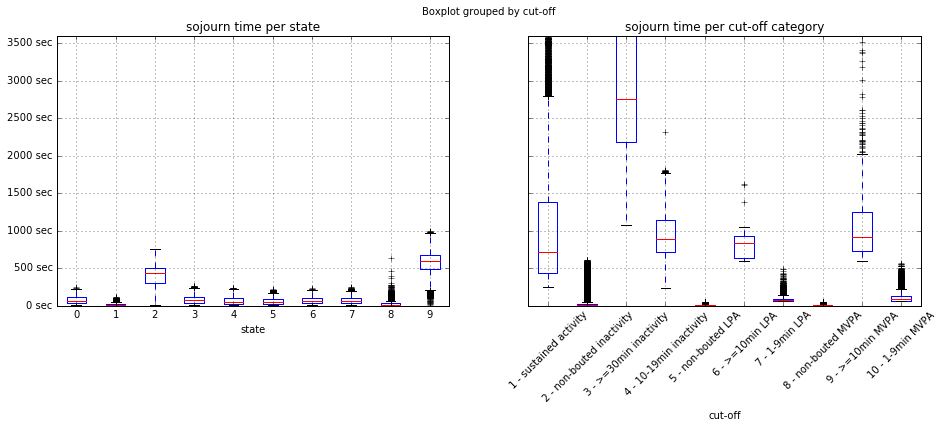

In [29]:
from matplotlib.ticker import FormatStrFormatter
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
fig.set_label('')
ymax = 60*60
sojourn_times_state.boxplot(by='state', column='time_sec', ax=axes[0])
axes[0].set_ylim(top=ymax)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%d sec'))
axes[0].set_title('sojourn time per state')
sojourn_times_cutoff.boxplot(by='cut-off', column='time_sec', ax=axes[1], rot=45)
axes[1].set_ylim(top=ymax)
axes[1].set_title('sojourn time per cut-off category')
plt.savefig(os.path.join(config.image_path, 'sojourn.png'))
#plt.show()

## Cross table activity - state

Let's compare the states with the known activities. First we have look at how many 5-seconds frame we have for each state/activity, and we sort from largest to smallest

In [79]:
ctab_long = pd.read_sql('''select label, state, count(*) from data_with_states group by label, state''', conn) 

In [80]:
ctab = ctab_long.pivot(index='label', columns='state', values='count(*)')

In [86]:
activities_simplified

,Label,"Locomotion (no=0,yes=1,unclear=2)","Frequent arm angle changes (no=0,yes=1,unclear=2)",SUM,Keep variable,Behavioural category,simplified_category
0,Sleeping and resting (including sick in bed),0,0,0,TRUE,0,"low motion, low arm changes"
1,"Did nothing, just relaxing, bored, waiting",0,0,0,TRUE,0,"low motion, low arm changes"
2,"Watch TV, DVDs, downloaded videos",0,0,0,TRUE,0,"low motion, low arm changes"
3,Eating a meal,0,1,1,TRUE,1,"low motion, high arm changes"
4,Reading (not for school),0,1,1,TRUE,1,"low motion, high arm changes"
5,"Answering emails, instant messaging, texting",0,1,1,TRUE,1,"low motion, high arm changes"
6,"Travel by physically active means (walk, bike ...",1,1,2,TRUE,2,"high motion, high arm changes"
7,"Other exercise and sports, dancing, keeping fi...",1,1,2,TRUE,2,"high motion, high arm changes"
8,"Fixing things around the house, fixing bike, g...",1,1,2,TRUE,2,"high motion, high arm changes"
9,"Team ball games and training (e.g. football, h...",1,1,2,TRUE,2,"high motion, high arm changes"


In [50]:
ctab_merged = ctab_long.merge(activities_simplified, left_on='label', right_on='Label')
ctab_simplified_long = ctab_merged.groupby(['simplified_category', 'state'])[['count(*)']].sum()
ctab_simplified = ctab_simplified_long.reset_index().pivot(index='simplified_category', columns='state', values='count(*)')

In [51]:
ctab_simplified

state,0,1,2,3,4,5,6,7,8,9
simplified_category,,,,,,,,,,
"high motion, high arm changes",71857,183511,20423,46240,87788,68934,115503,224845,111291,15508
"low motion, high arm changes",89035,114931,24258,65241,77902,58290,98899,117103,39657,21964
"low motion, low arm changes",427617,381668,829031,439361,511720,266182,591879,419300,95840,1286622
"low motion, mixed arm changes",304901,477374,79475,212885,314216,216794,469302,468062,149431,78720
"mixed motion, high arm changes",81108,122054,36228,50835,79462,65479,88016,121425,44018,34915
"mixed motion, low arm changes",10836,20855,3086,4549,17012,8092,17695,21134,7365,2056
"mixed motion, mixed arm changes",157281,258544,41535,96064,163828,110240,179631,269504,92290,46783


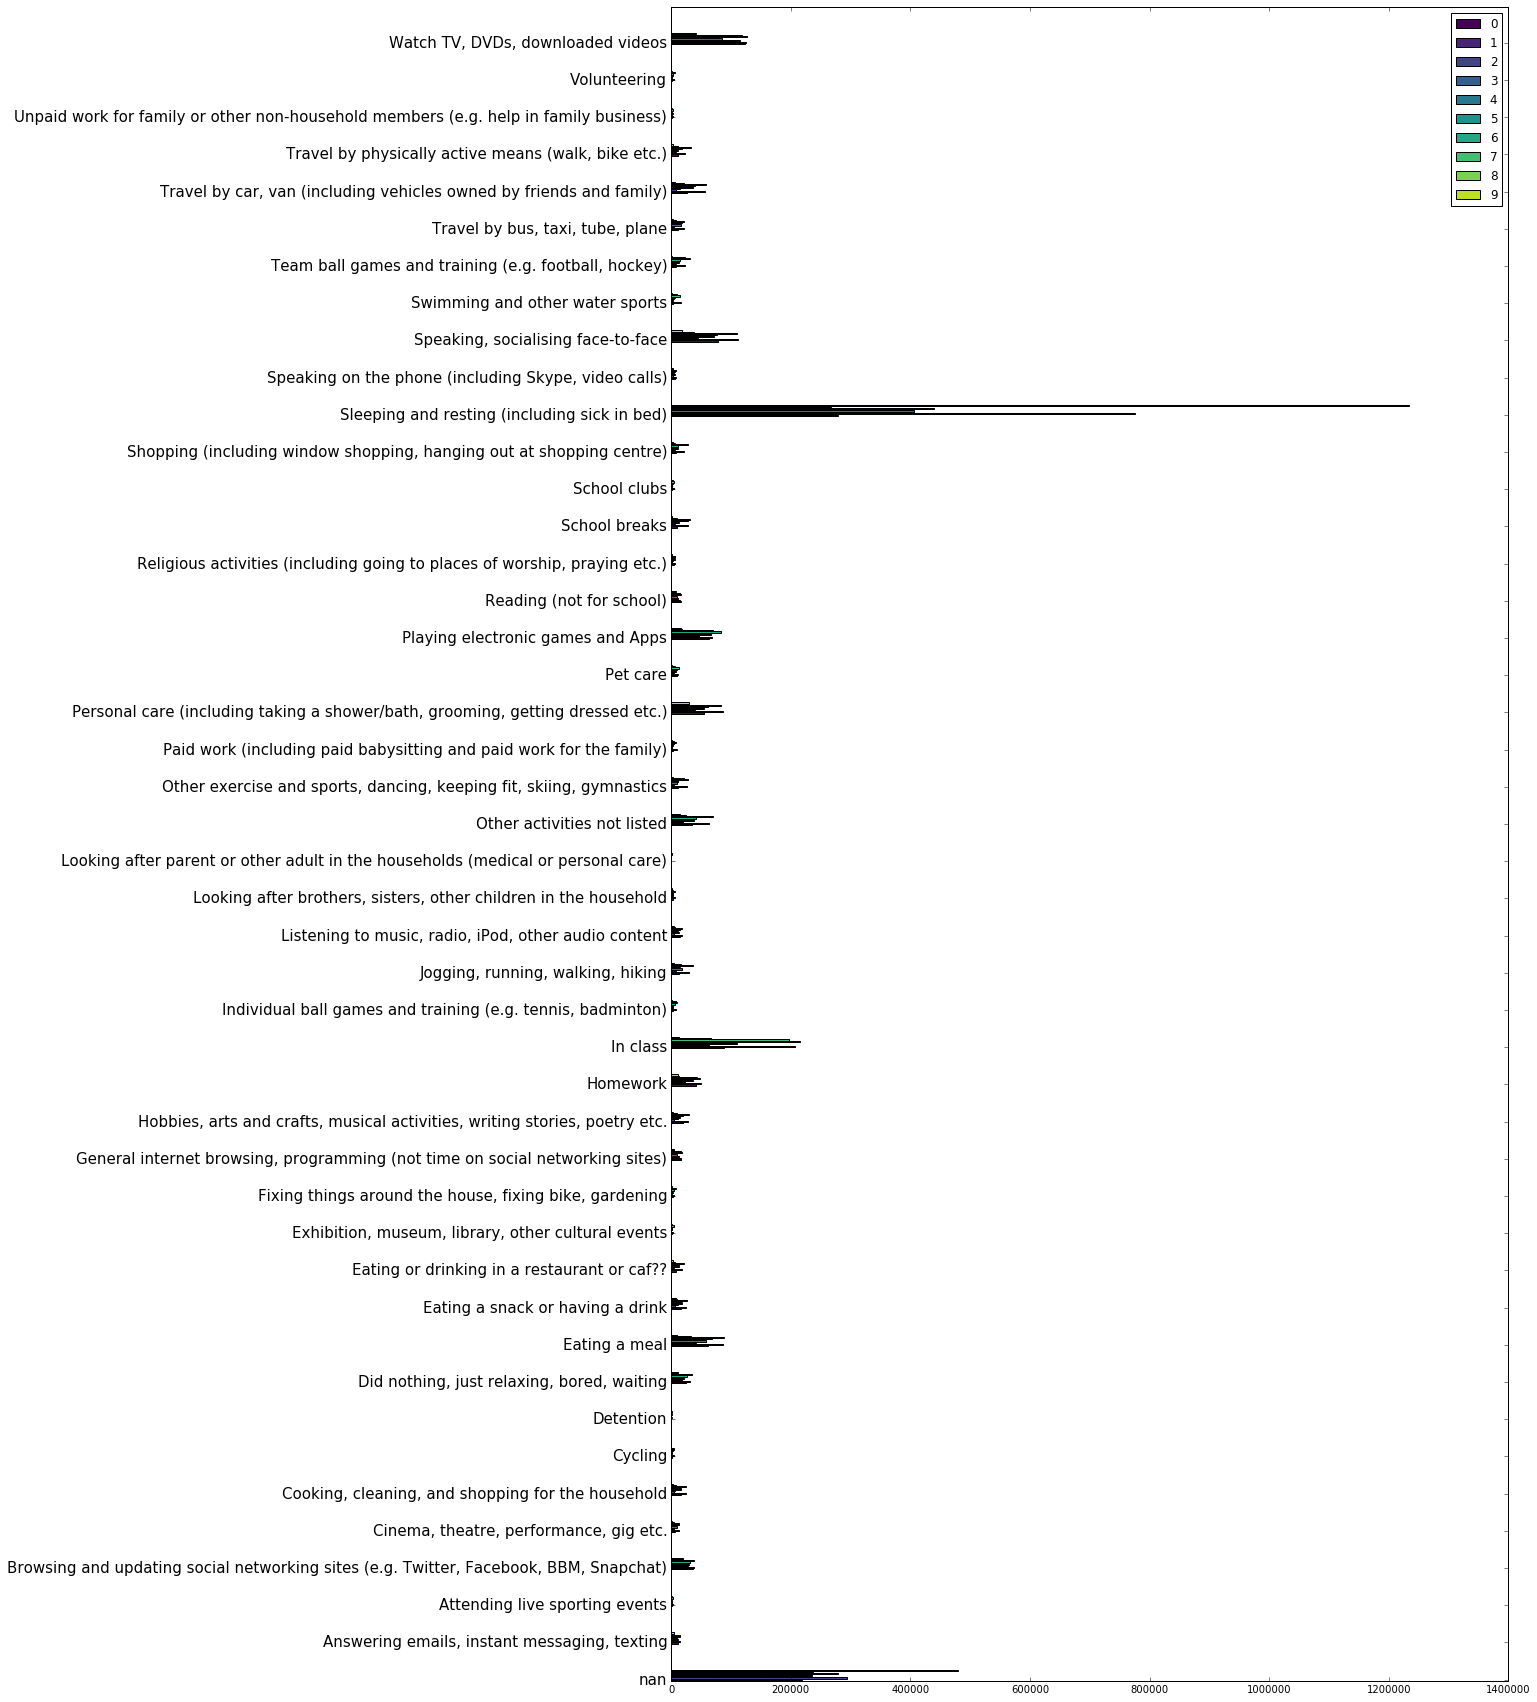

In [52]:
from __future__ import unicode_literals
fig, ax = plt.subplots(figsize=(15,30))

states = ctab.columns
acts = ctab.index

n_groups = len(acts)
index = len(states)*np.arange(n_groups)
bar_width = 1./len(states)*3
colors = colormap

#Draw all states, but don't draw All
for i in range(len(states)):
    rects1 = plt.barh(index + i*bar_width, 
                     ctab[states[i]], 
                     bar_width,
                     color=colors[i],
                     label=states[i])

plt.yticks(index + bar_width, ctab.index, fontsize=15)
plt.legend()

#Set maximum to something reasonable, namely the maximum of not-all
#ax.set_xlim(0, ctab[states[-1]][acts[1]])
plt.show()

In [53]:
#Now normalize over the activity and sort by total number
ctab_norm1 = ctab_simplified.copy()
ctab_norm1.loc['All',:] = ctab_norm1.sum()
ctab_norm1 = ctab_norm1.divide(ctab_norm1.sum(axis=1), axis='index')

In [54]:
ctab_norm1.style.background_gradient(cmap='BuGn',axis=1)

state,0,1,2,3,4,5,6,7,8,9
simplified_category,,,,,,,,,,
"high motion, high arm changes",0.0759668,0.194007,0.0215911,0.0488847,0.092809,0.0728766,0.122109,0.237705,0.117656,0.016395
"low motion, high arm changes",0.125884,0.162497,0.0342976,0.0922421,0.110143,0.0824143,0.13983,0.165568,0.0560697,0.0310542
"low motion, low arm changes",0.081463,0.0727095,0.157934,0.0837002,0.097485,0.0507089,0.112756,0.0798785,0.018258,0.245107
"low motion, mixed arm changes",0.110026,0.172265,0.0286793,0.0768216,0.113388,0.0782322,0.169352,0.168905,0.0539236,0.0284069
"mixed motion, high arm changes",0.112099,0.16869,0.0500705,0.0702587,0.109824,0.0904981,0.121646,0.167821,0.060837,0.0482558
"mixed motion, low arm changes",0.0961661,0.185082,0.0273873,0.040371,0.150976,0.071814,0.157038,0.187558,0.0653621,0.0182464
"mixed motion, mixed arm changes",0.111098,0.182626,0.0293388,0.0678562,0.115722,0.0778696,0.126885,0.190368,0.0651904,0.0330458
All,0.0958146,0.130723,0.0867081,0.0767411,0.104979,0.0665811,0.13089,0.137636,0.0452721,0.124655


In [55]:
ctab_norm2 = ctab_simplified.copy()
ctab_norm2['All'] = ctab_norm2.sum(axis=1)
ctab_norm2.divide(ctab_norm2.sum(axis=0), axis='columns')

state,0,1,2,3,4,5,6,7,8,9,All
simplified_category,,,,,,,,,,,
"high motion, high arm changes",0.062887,0.117715,0.019751,0.050526,0.070122,0.086817,0.073997,0.136986,0.206136,0.010432,0.079318
"low motion, high arm changes",0.077921,0.073724,0.023460,0.071288,0.062226,0.073412,0.063359,0.071345,0.073454,0.014775,0.059308
"low motion, low arm changes",0.374238,0.244826,0.801743,0.480084,0.408746,0.335237,0.379185,0.255457,0.177517,0.865498,0.440168
"low motion, mixed arm changes",0.266840,0.306218,0.076859,0.232617,0.250986,0.273037,0.300656,0.285165,0.276779,0.052954,0.232373
"mixed motion, high arm changes",0.070983,0.078293,0.035036,0.055547,0.063472,0.082466,0.056387,0.073978,0.081531,0.023487,0.060672
"mixed motion, low arm changes",0.009483,0.013378,0.002984,0.004971,0.013589,0.010191,0.011336,0.012876,0.013642,0.001383,0.009449
"mixed motion, mixed arm changes",0.137648,0.165846,0.040168,0.104968,0.130861,0.138839,0.115080,0.164194,0.170942,0.031470,0.118712


In [56]:
#Now normalize over state and sort by total number
#ind = list(ctab.index)
ctab_norm2 = ctab_simplified.copy()
ctab_norm2.loc['All'] = ctab_norm2.sum(axis=0)
ctab_norm2 = ctab_norm2.divide(ctab_norm2.sum(axis=1), axis='rows')

In [57]:
ctab_norm2.style.background_gradient(cmap='BuGn',axis=0)

state,0,1,2,3,4,5,6,7,8,9
simplified_category,,,,,,,,,,
"high motion, high arm changes",0.0759668,0.194007,0.0215911,0.0488847,0.092809,0.0728766,0.122109,0.237705,0.117656,0.016395
"low motion, high arm changes",0.125884,0.162497,0.0342976,0.0922421,0.110143,0.0824143,0.13983,0.165568,0.0560697,0.0310542
"low motion, low arm changes",0.081463,0.0727095,0.157934,0.0837002,0.097485,0.0507089,0.112756,0.0798785,0.018258,0.245107
"low motion, mixed arm changes",0.110026,0.172265,0.0286793,0.0768216,0.113388,0.0782322,0.169352,0.168905,0.0539236,0.0284069
"mixed motion, high arm changes",0.112099,0.16869,0.0500705,0.0702587,0.109824,0.0904981,0.121646,0.167821,0.060837,0.0482558
"mixed motion, low arm changes",0.0961661,0.185082,0.0273873,0.040371,0.150976,0.071814,0.157038,0.187558,0.0653621,0.0182464
"mixed motion, mixed arm changes",0.111098,0.182626,0.0293388,0.0678562,0.115722,0.0778696,0.126885,0.190368,0.0651904,0.0330458
All,0.0958146,0.130723,0.0867081,0.0767411,0.104979,0.0665811,0.13089,0.137636,0.0452721,0.124655


Check if there is a significant correlation between the states and the activities:

In [81]:
ctab['All'] = ctab.sum(axis=1)
ctab = ctab.sort_values('All', ascending=False)
ctab = ctab.fillna(0)

In [82]:
topactivities = 10 # take most frequent activities
counts = ctab.as_matrix()[1:1+topactivities,:-1]
chi2, p, dof, expected = scipy.stats.chi2_contingency(counts)

print(chi2, p)

1128271.93986 0.0


In [85]:
ctab_reordered = ctab[state_order]

ctab_reordered.head(15).style.background_gradient(cmap='BuGn',axis=1)

state,9,2,0,3,4,6,5,1,7,8
label,,,,,,,,,,
Sleeping and resting (including sick in bed),1.23412e+06,775760,279392,305424,405539,439871,180877,225256,266820,51656
nan,479747,294105,208785,156217,236162,278666,121677,218363,236993,76105
In class,13396,19456,88223,63281,109911,215192,82080,206227,197689,67265
"Watch TV, DVDs, downloaded videos",41077,43327,123301,115296,85590,125929,70654,125746,117960,33780
"Speaking, socialising face-to-face",17130,13312,78292,45138,71844,77235,46180,112018,110571,37700
"Personal care (including taking a shower/bath, grooming, getting dressed etc.)",29393,29105,55375,39740,55164,60853,44201,86095,83139,30355
Eating a meal,9548,15448,61195,41963,58380,67622,43692,86623,87432,32157
Playing electronic games and Apps,16296,14310,63834,46668,66070,82515,34397,67699,70364,17427
Other activities not listed,14912,10538,33892,20066,38507,41082,30691,62960,69601,24191


In [86]:
# Only easy interpreted activities
activities = ['Sleeping and resting (including sick in bed)', 'Jogging, running, walking, hiking']
ctab_sub = ctab[[a in activities for a in ctab.index]][state_order]
ctab_sub.style.background_gradient(cmap='BuGn',axis=1)

state,9,2,0,3,4,6,5,1,7,8
label,,,,,,,,,,
Sleeping and resting (including sick in bed),1.23412e+06,775760,279392,305424,405539,439871,180877,225256,266820,51656
"Jogging, running, walking, hiking",4005,4217,13358,7286,17129,14922,12493,30237,35672,16981


# State vs activity, per person

In [87]:
activity_states = pd.read_sql('''select d.filename, d.state, d.label, count(*)
                from data_with_states d
                join timecounts t
                on t.filename = d.filename
                where t.cnt_hours > 20
                group by d.filename, d.state, d.label;''', 
                               conn)

In [115]:
nr_subjects = len(activity_states['filename'].unique())
ctab_original = activity_states.groupby(['label', 'state'])['count(*)'].sum()
ctab_original = ctab_original.unstack(level=-1)
ctab_original = ctab_original.fillna(0)
ctab = ctab_original / nr_subjects
ctab = ctab[state_order]
ctab['total'] = activity_states.groupby(['label'])['count(*)'].sum() / nr_subjects
ctab = ctab.sort_values('total', ascending=False)
ctab.loc['total',] = ctab.sum(axis=0) 
ctab = ctab / 12.0
ctab

state,9,2,0,3,4,6,5,1,7,8,total
label,,,,,,,,,,,
Sleeping and resting (including sick in bed),132.158560,81.270505,27.171316,30.823200,41.679542,45.827372,17.871125,21.752980,26.578922,4.737721,429.871245
In class,0.910706,1.521459,7.950167,6.180019,10.037315,20.512876,7.972938,19.872079,18.602647,6.368264,99.928469
"Watch TV, DVDs, downloaded videos",4.371602,4.447663,12.679542,11.321888,8.846447,12.783023,7.179900,12.585837,11.735336,3.404983,89.356223
"Speaking, socialising face-to-face",1.476633,1.002265,7.652361,4.071531,6.760134,6.978302,3.966381,10.509895,10.367907,3.630901,56.416309
"Personal care (including taking a shower/bath, grooming, getting dressed etc.)",2.894134,2.670124,5.242847,3.578445,5.293753,5.842990,4.304840,8.268240,8.355508,2.905341,49.356223
Eating a meal,0.976514,1.234740,5.645207,4.070696,5.872556,6.682523,4.030162,8.489866,8.607773,3.023724,48.633763
Playing electronic games and Apps,1.654864,1.351335,6.626967,4.625656,6.320815,8.448140,3.408679,6.823915,6.714950,1.671316,47.646638
Other activities not listed,1.237124,0.973772,3.029924,1.959943,3.513948,3.671078,2.789461,5.950763,6.798760,2.314139,32.238913
Homework,1.163686,0.964473,3.821769,2.469123,3.635074,4.836433,2.302933,4.824988,4.317477,1.263472,29.599428


In [120]:
ctab_f = ctab.applymap(lambda c: '{:.1f}'.format(c))

In [108]:
nr_subjects

699

In [125]:
ctab[state_order].style.background_gradient(cmap='BuGn',axis=1)

state,9,2,0,3,4,6,5,1,7,8
label,,,,,,,,,,
Sleeping and resting (including sick in bed),132.159,81.2705,27.1713,30.8232,41.6795,45.8274,17.8711,21.753,26.5789,4.73772
In class,0.910706,1.52146,7.95017,6.18002,10.0373,20.5129,7.97294,19.8721,18.6026,6.36826
"Watch TV, DVDs, downloaded videos",4.3716,4.44766,12.6795,11.3219,8.84645,12.783,7.1799,12.5858,11.7353,3.40498
"Speaking, socialising face-to-face",1.47663,1.00227,7.65236,4.07153,6.76013,6.9783,3.96638,10.5099,10.3679,3.6309
"Personal care (including taking a shower/bath, grooming, getting dressed etc.)",2.89413,2.67012,5.24285,3.57845,5.29375,5.84299,4.30484,8.26824,8.35551,2.90534
Eating a meal,0.976514,1.23474,5.64521,4.0707,5.87256,6.68252,4.03016,8.48987,8.60777,3.02372
Playing electronic games and Apps,1.65486,1.35134,6.62697,4.62566,6.32082,8.44814,3.40868,6.82392,6.71495,1.67132
Other activities not listed,1.23712,0.973772,3.02992,1.95994,3.51395,3.67108,2.78946,5.95076,6.79876,2.31414
Homework,1.16369,0.964473,3.82177,2.46912,3.63507,4.83643,2.30293,4.82499,4.31748,1.26347


## Look more into depth into sleep

In [10]:
data_sleep = pd.read_sql('''select filename, timestamp, subset, heuristic, state, label from data_with_states where label="Sleeping and resting (including sick in bed)" ''', conn) 

In [11]:
data_sleep.head()

,filename,timestamp,subset,heuristic,state,label
0,__022116_2015-07-09 14-13-48.bin_day2.csv,2015-06-30 21:30:00,1,3,6,Sleeping and resting (including sick in bed)
1,__022116_2015-07-09 14-13-48.bin_day2.csv,2015-06-30 21:30:05,1,3,6,Sleeping and resting (including sick in bed)
2,__022116_2015-07-09 14-13-48.bin_day2.csv,2015-06-30 21:30:10,1,3,6,Sleeping and resting (including sick in bed)
3,__022116_2015-07-09 14-13-48.bin_day2.csv,2015-06-30 21:30:15,1,3,6,Sleeping and resting (including sick in bed)
4,__022116_2015-07-09 14-13-48.bin_day2.csv,2015-06-30 21:30:20,1,3,6,Sleeping and resting (including sick in bed)


In [12]:
data_sleep.timestamp2 = pd.to_datetime(data_sleep.timestamp)

In [13]:
data_sleep['time'] = data_sleep.timestamp2.dt.time

In [15]:
state_order = [9, 2, 0, 3, 4, 6, 5, 1, 7, 8]

In [16]:
data_sleep_grouped = data_sleep.groupby(['time', 'state'])['filename'].count()
data_sleep_grouped = data_sleep_grouped.unstack()[state_order]

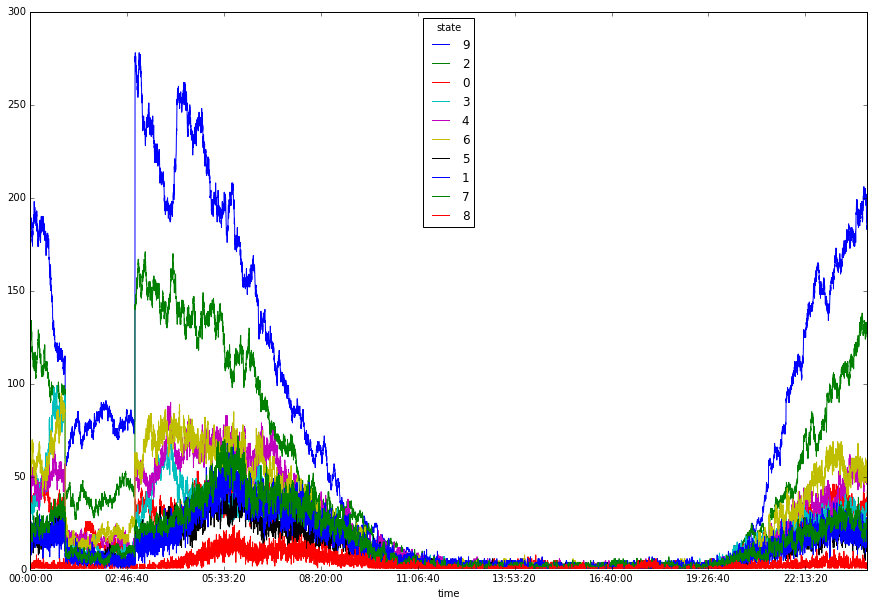

In [17]:
data_sleep_grouped.plot(figsize=(15,10));

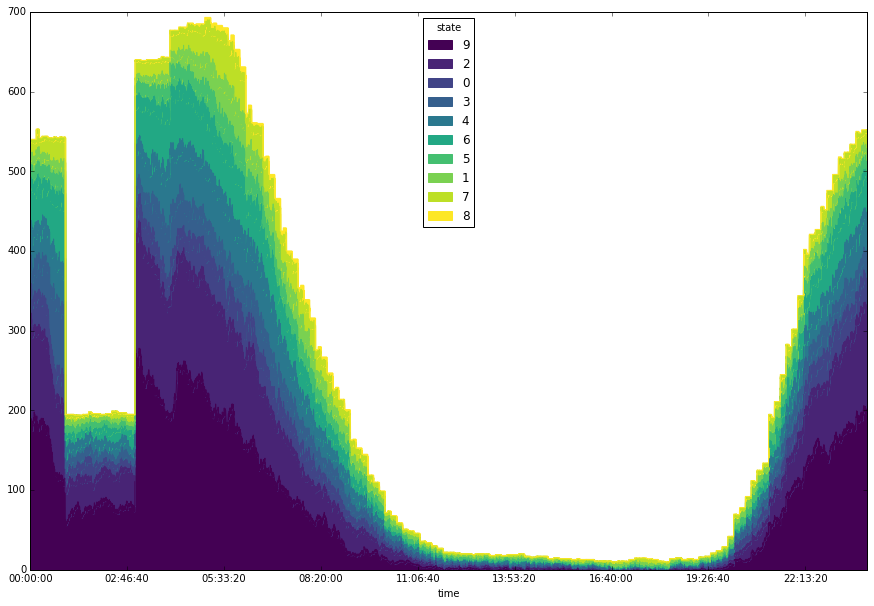

In [22]:
data_sleep_grouped.plot(figsize=(15,10), kind='area', stacked=True, colormap=cmap);

In [35]:
data_sleep_grouped = data_sleep_grouped.fillna(0)
counts = data_sleep_grouped.mean(axis=1)
data_sleep_grouped_norm = pd.DataFrame((data_sleep_grouped.as_matrix().transpose() / counts.as_matrix()).transpose())
data_sleep_grouped_norm.index = data_sleep_grouped.index

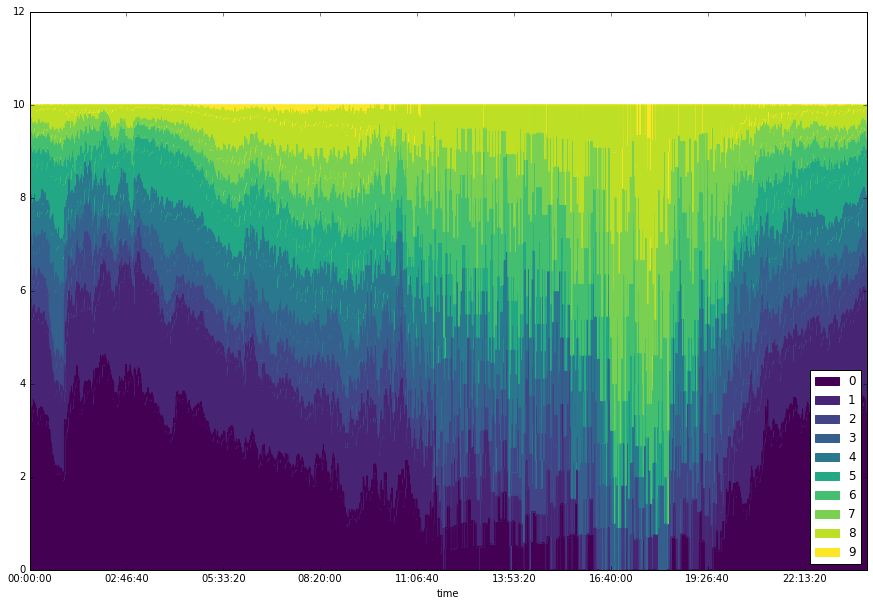

In [38]:
data_sleep_grouped_norm.plot(figsize=(15,10), kind='area', stacked=True, colormap=cmap);

## Compare with heuristic

In [30]:
ctab_heuristic_long = pd.read_sql('''select heuristic, state, count(*) from data_with_states group by heuristic, state''', conn)

In [31]:
ctab_heuristic = ctab_heuristic_long.pivot(index='heuristic', columns='state', values='count(*)').fillna(0)

In [32]:
ctab_heuristic.index = [get_heuristic(i) for i in ctab_heuristic.index]

In [33]:
ctab_heuristic_norm = ctab_heuristic.divide(ctab_heuristic.sum(axis=0), axis=1)
ctab_heuristic_norm.style.background_gradient(cmap='BuGn',axis=0)

state,0,1,2,3,4,5,6,7,8,9
1 - sustained activity,0.220616,0.0285135,0.776152,0.00244041,0.273313,0.0224963,0.187733,0.0687508,0.00159368,0.954802
2 - non-bouted inactivity,0.236071,0.231506,0.0476488,0.27734,0.296317,0.312455,0.290216,0.254433,0.0400831,0.0109357
3 - >=30min inactivity,0.371027,0.157993,0.123708,0.476469,0.256152,0.202597,0.32289,0.157639,0.0292823,0.0215023
4 - 10-19min inactivity,0.170402,0.0846517,0.0524915,0.242095,0.157651,0.130705,0.178903,0.0804168,0.0123993,0.0127596
5 - non-bouted LPA,0.00173897,0.376687,0,0.00162911,0.0162111,0.222807,0.0193161,0.231022,0.116562,0
6 - >=10min LPA,1.47059e-06,0.000991808,0,3.71731e-06,3.99945e-06,0.000351793,2.32158e-05,0.000594354,0.00044983,0
7 - 1-9min LPA,0,0.0352646,0,0,0.000229302,0.0276787,0.000869784,0.0294829,0.0115655,0
8 - non-bouted MVPA,0,0.0585896,0,0,0,0.0582283,0,0.0991134,0.378269,0
9 - >=10min MVPA,0.000143382,0.0106643,0,2.23038e-05,0.000119984,0.00780459,4.85913e-05,0.0308074,0.155026,0
10 - 1-9min MVPA,0,0.0151389,0,0,2.6663e-06,0.0148763,0,0.047741,0.254769,0


In [34]:
ctab_heuristic_norm = ctab_heuristic.divide(ctab_heuristic.sum(axis=1), axis=0)
ctab_heuristic_norm.style.background_gradient(cmap='BuGn',axis=1)

state,0,1,2,3,4,5,6,7,8,9
1 - sustained activity,0.0718167,0.0122557,0.24725,0.000628558,0.0981436,0.00495929,0.0832294,0.0312591,0.000237445,0.45022
2 - non-bouted inactivity,0.110776,0.143437,0.0218804,0.102969,0.15338,0.0992907,0.185468,0.166757,0.00860862,0.00743309
3 - >=30min inactivity,0.168502,0.0947404,0.0549792,0.171209,0.128325,0.0623091,0.19971,0.0999936,0.00608662,0.0141451
4 - 10-19min inactivity,0.145938,0.0957253,0.043993,0.164049,0.148937,0.0758063,0.208668,0.0961945,0.00486026,0.0158289
5 - non-bouted LPA,0.00162294,0.464183,0,0.00120297,0.0166892,0.140818,0.0245514,0.301143,0.0497897,0
6 - >=10min LPA,0.000560381,0.499019,0,0.00112076,0.00168114,0.0907817,0.0120482,0.316335,0.0784533,0
7 - 1-9min LPA,0,0.411268,0,0,0.00223413,0.165559,0.0104627,0.363721,0.0467543,0
8 - non-bouted MVPA,0,0.180598,0,0,0,0.0920551,0,0.323175,0.404172,0
9 - >=10min MVPA,0.00107235,0.10531,0,0.000131981,0.000989859,0.0395284,0.00049493,0.321814,0.530658,0
10 - 1-9min MVPA,0,0.09369,0,0,1.37855e-05,0.0472189,0,0.312539,0.546538,0


## Heuristic vs states, per person

In [106]:
heuristic_states = pd.read_sql('''select d.filename, d.state, d.heuristic, count(*)
                from data_with_states d
                join timecounts t
                on t.filename = d.filename
                where t.cnt_hours > 20
                group by d.filename, d.state, d.heuristic;''', 
                               conn)

In [112]:
nr_subjects = len(heuristic_states['filename'].unique())
ctab_original = heuristic_states.groupby(['state', 'heuristic'])['count(*)'].sum()
ctab_original = ctab_original.unstack(level=-1)
ctab_original = ctab_original.fillna(0)
ctab = ctab_original / nr_subjects
ctab['total'] = heuristic_states.groupby(['state'])['count(*)'].sum() / nr_subjects
ctab.loc['total',] = ctab.sum(axis=0) 
ctab.applymap(lambda c: float(c)/nr_subjects)
ctab.applymap(lambda c: float(c)/12.0)
ctab.columns = [get_heuristic(i) for i in ctab.columns[:-1]] + ['total']
ctab_f = ctab.applymap(lambda c: '{:.0f}'.format(c))

In [113]:
ctab_f

,1 - sustained activity,2 - non-bouted inactivity,3 - >=30min inactivity,4 - 10-19min inactivity,5 - non-bouted LPA,6 - >=10min LPA,7 - 1-9min LPA,8 - non-bouted MVPA,9 - >=10min MVPA,10 - 1-9min MVPA,total
state,,,,,,,,,,,
0,348,378,553,277,3,0,0,0,0,0,1559
1,63,488,330,179,787,1,73,122,22,31,2097
2,1266,78,147,85,0,0,0,0,0,0,1576
3,3,358,596,310,2,0,0,0,0,0,1270
4,514,524,407,276,28,0,0,0,0,0,1750
5,24,333,212,140,233,0,28,60,7,16,1055
6,440,630,710,392,41,0,2,0,0,0,2214
7,162,565,338,176,519,1,65,225,69,108,2227
8,1,29,20,9,84,0,8,273,110,186,721


In [53]:
#obs = ctab_original.as_matrix()
obs = ctab.as_matrix()[:-1,:-1]
expected = np.outer(obs.sum(axis=1), obs.sum(axis=0))/obs.sum()
scipy.stats.chisquare(obs, expected, axis=None)

Power_divergenceResult(statistic=19689.366345288978, pvalue=0.0)

In [115]:
ctab.transpose()[list(state_order)+['total']]

state,9,2,0,3,4,6,5,1,7,8,total
1 - sustained activity,2364.841202,1265.688126,347.919886,3.343348,513.638054,439.884120,24.454936,63.263233,161.525036,1.211731,5185.769671
2 - non-bouted inactivity,27.078684,77.788269,378.261803,357.828326,524.020029,629.992847,333.336195,488.250358,564.865522,29.123033,3410.545064
3 - >=30min inactivity,48.974249,147.257511,552.962804,596.241774,407.217454,709.599428,211.542203,329.699571,337.812589,19.944206,3361.251788
4 - 10-19min inactivity,30.628040,85.064378,276.769671,310.257511,276.307582,391.559371,140.008584,178.793991,176.014306,9.115880,1874.519313
5 - non-bouted LPA,0.000000,0.000000,2.743920,2.014306,28.417740,41.155937,232.997139,787.480687,519.067239,84.206009,1698.082976
6 - >=10min LPA,0.000000,0.000000,0.002861,0.000000,0.004292,0.048641,0.449213,1.257511,1.024320,0.258941,3.045780
7 - 1-9min LPA,0.000000,0.000000,0.000000,0.000000,0.406295,2.028612,27.876967,73.383405,65.030043,8.241774,176.967096
8 - non-bouted MVPA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.472103,121.888412,224.954220,273.263233,680.577969
9 - >=10min MVPA,0.000000,0.000000,0.250358,0.028612,0.198856,0.098712,7.391989,21.988555,68.766810,109.539342,208.263233
10 - 1-9min MVPA,0.000000,0.000000,0.000000,0.000000,0.005722,0.000000,16.158798,31.110157,107.885551,185.645207,340.805436


## Distributions for the heuristic levels

## States for an example sequence

In [20]:
example_index = 674

In [21]:
fn = filenames[example_index]
data = pd.read_csv(os.path.join(config.states_path,fn), encoding='utf-8', index_col='timestamp', parse_dates=True)
data.head()

,acceleration,EN,anglex,angley,anglez,roll_med_acc_x,roll_med_acc_y,roll_med_acc_z,dev_roll_med_acc_x,dev_roll_med_acc_y,...,filename,subset,switched_pos,binFile,day,slot,activity,label,start_time,state
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-02-01 04:00:00,0.003742,1.002215,-74.811432,-11.790929,9.437138,-0.967162,-0.204785,0.164322,0.000260,-6.379302e-04,...,__022078_2015-02-19 14-59-12.bin_day1.csv,0,True,__022078_2015-02-19 14-59-12.bin,1,1,1.0,Sleeping and resting (including sick in bed),2015-02-01T04:00:00+0000,4
2015-02-01 04:00:05,0.003613,1.002191,-74.770741,-11.788622,9.503554,-0.967162,-0.204785,0.165499,0.000301,-5.581890e-04,...,__022078_2015-02-19 14-59-12.bin_day1.csv,0,True,__022078_2015-02-19 14-59-12.bin,1,1,1.0,Sleeping and resting (including sick in bed),2015-02-01T04:00:00+0000,4
2015-02-01 04:00:10,0.003944,1.002363,-74.786339,-11.789506,9.478095,-0.967162,-0.204785,0.165048,-0.000200,-8.326673e-19,...,__022078_2015-02-19 14-59-12.bin_day1.csv,0,True,__022078_2015-02-19 14-59-12.bin,1,1,1.0,Sleeping and resting (including sick in bed),2015-02-01T04:00:00+0000,4
2015-02-01 04:00:15,0.003535,1.001931,-74.873145,-11.794428,9.336406,-0.967162,-0.204785,0.162535,-0.000040,6.578656e-04,...,__022078_2015-02-19 14-59-12.bin_day1.csv,0,True,__022078_2015-02-19 14-59-12.bin,1,1,1.0,Sleeping and resting (including sick in bed),2015-02-01T04:00:00+0000,4
2015-02-01 04:00:20,0.004246,1.002911,-74.939609,-11.694158,9.356542,-0.967198,-0.203013,0.162838,-0.000835,-1.099792e-03,...,__022078_2015-02-19 14-59-12.bin_day1.csv,0,True,__022078_2015-02-19 14-59-12.bin,1,1,1.0,Sleeping and resting (including sick in bed),2015-02-01T04:00:00+0000,4


In [22]:
hidden_states = data['state']

In [102]:
from pyhsmm.util.general import rle
from matplotlib.dates import date2num, AutoDateLocator

def plot_states_and_var(data, hidden_states, state_order = None, cmap=None, columns=None, by=None, by_labels=None):
    """
    Make  a plot of the data and the states
    Parameters
    ----------
    data : pandas DataFrame
        Data to plot
    hidden_states: iteretable
        the hidden states corresponding to the timesteps
    columns : list, optional
        Which columns to plot
    by : iteretable
        The column to group on
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    if columns is None:
        columns = data.columns
    df = data[columns].copy()
    stateseq = np.array(hidden_states)
    stateseq_norep, durations = rle(stateseq)
    datamin, datamax = np.array(df).min(), np.array(df).max()
    y = np.array(
        [datamin, datamax])
    maxstate = stateseq.max() + 1
    
    if state_order is None:
        state_order = np.arange(maxstate)
    state_order_dict = {state_order[i]: i for i in range((len(state_order)))}
    x = np.hstack(([0], durations.cumsum()[:-1], [len(df.index) - 1]))
    C = np.array(
        [[float(state_order_dict[state]) / maxstate] for state in stateseq_norep]).transpose()
    ax.set_xlim((min(x), max(x)))

    if cmap is None:
        num_states = max(hidden_states) + 1
        colormap, cmap = get_color_map(num_states)
    pc = ax.pcolorfast(x, y, C, vmin=0, vmax=1, alpha=0.3, cmap=cmap)
    plt.plot(df.as_matrix())
    locator = AutoDateLocator()
    locator.create_dummy_axis()
    num_index = pd.Index(df.index.map(date2num))
    ticks_num = locator.tick_values(min(df.index), max(df.index))
    ticks = [num_index.get_loc(t) for t in ticks_num]
    plt.xticks(ticks, df.index.strftime('%H:%M')[ticks], rotation='vertical')
    #cb = plt.colorbar(pc)
    #cb.set_ticks(np.arange(1./(2*cmap.N), 1, 1./cmap.N))
    #cb.set_ticklabels(state_order)
    # Plot the activities
    if by is not None:
        sca = ax.scatter(
            np.arange(len(hidden_states)), #data.index,
            np.ones_like(hidden_states) * datamax,
            c=by,
            cmap=cmap,
            edgecolors='none'
        )
        if by_labels is not None:
            cb2 = plt.colorbar(sca)
            cb2.set_ticks(np.arange(1./2., cmap.N-0.5, 1))
            cb2.set_ticklabels(by_labels)
    return fig, ax

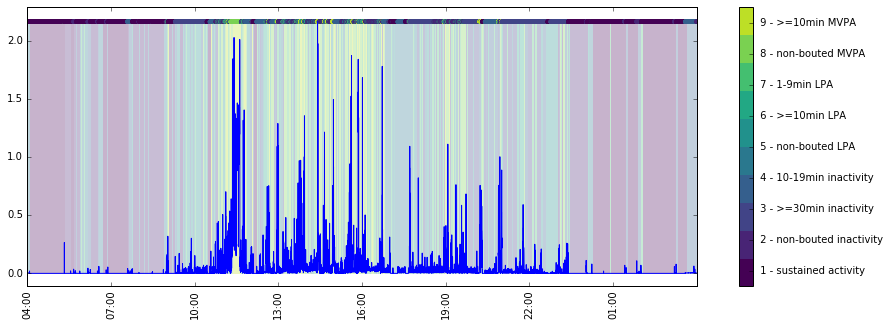

In [103]:
heuristic_seq = np.array(data['heuristic']) - 1
fig, ax = plot_states_and_var(data, hidden_states, state_order=state_order, 
                              columns=['acceleration',], by=heuristic_seq, by_labels = heuristic_classes,
                              cmap=cmap_states);
cbar = ax.images[-1].colorbar
#cbar.set_ticklabels(state_order)
#cbar.ax.invert_yaxis() 
plt.show()

In [101]:
np.arange(1./2., cmap.N-0.5, 1)

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5])

In [105]:
min(heuristic_seq), max(heuristic_seq)

(0, 9)

(1440, 23)


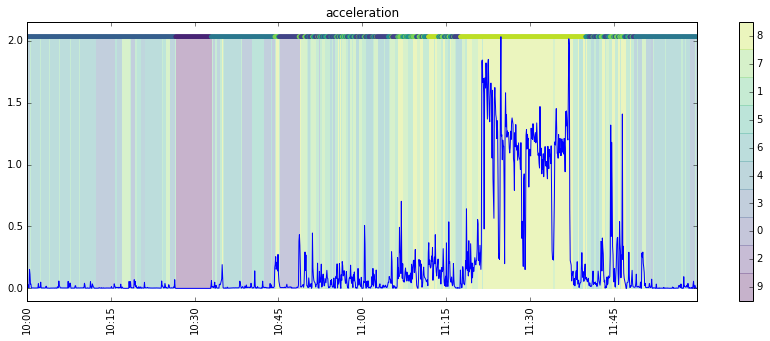

In [67]:
start =int(6*12*60)
end = 8*12*60
print(data[start:end].shape)
fig, ax = plot_states_and_var(data[start:end], hidden_states[start:end], state_order=state_order, cmap=cmap_states, columns=['acceleration'], by='heuristic')
ax.set_title('acceleration')

(1440, 23)


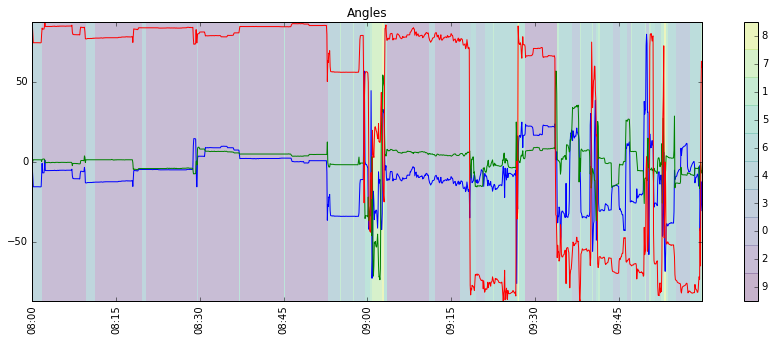

In [64]:
start =int(4*12*60)
end = 6*12*60
print(data[start:end].shape)
fig, ax = plot_states_and_var(data[start:end], hidden_states[start:end], state_order=state_order, cmap=cmap_states, columns=['anglex', 'angley', 'anglez'], by=None)
ax.set_title('Angles')

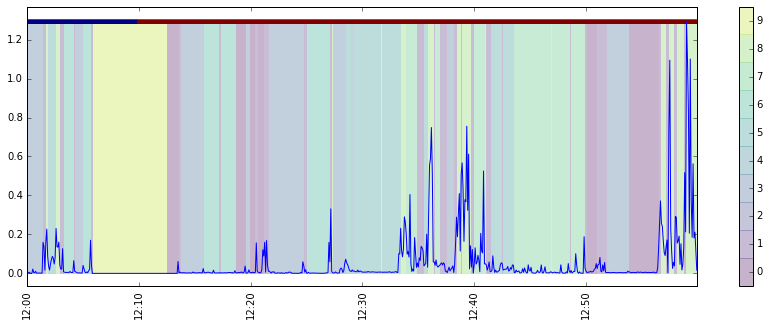

(<matplotlib.figure.Figure at 0x7fa2dcf5b3d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa2d9b4a710>)

In [77]:
start =int(8*12*60)
end = 9*12*60
hsmm.plot_states_and_var(data[start:end], hidden_states[start:end], cmap=cmap_states, columns=['acceleration'], by='activity')

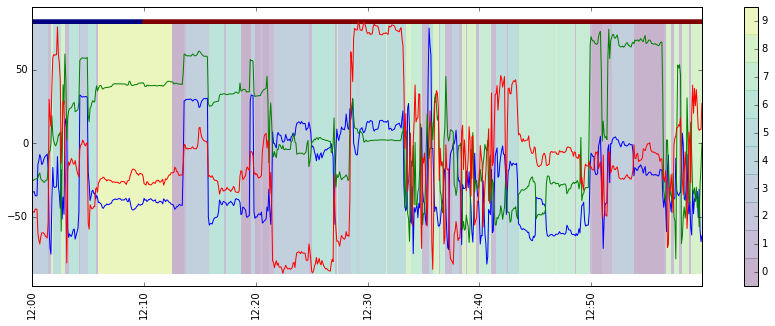

(<matplotlib.figure.Figure at 0x7fa2d956bb50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa2d9766750>)

In [78]:
hsmm.plot_states_and_var(data[start:end], hidden_states[start:end], cmap=cmap_states, columns=['anglex', 'angley', 'anglez'], by='activity')